

Three datasets used:
* Raw EEG Data
* Raw Spectrogram Data (NAs filled by 0)
* Spectrogram data built by EEGs (<a href=https://www.kaggle.com/datasets/cdeotte/brain-eeg-spectrograms/data)>Spectrogram Data Built from EEGs, Thank you, Chris Deotte</a>)

In [1]:
import pandas as pd
import numpy as np
from scipy.special import kl_div
from sklearn.model_selection import GroupKFold
import xgboost as xgb
from tqdm.notebook import tqdm

In [2]:
class ReadData():
    def __init__(self, is_train = True):
        self.is_train = is_train
    
    def _read_data(self, data_type, file_id):
        if self.is_train:
            PATH = f"/kaggle/input/hms-harmful-brain-activity-classification/train_{data_type}/{file_id}.parquet"
        else:
            PATH = f"/kaggle/input/hms-harmful-brain-activity-classification/test_{data_type}/{file_id}.parquet"
        
        return pd.read_parquet(PATH)
        
    def read_spectrogram_data(self, spectrogram_id):
        return self._read_data('spectrograms', spectrogram_id).set_index('time')
    
    def read_train_data(self):
        return pd.read_csv("/kaggle/input/hms-harmful-brain-activity-classification/train.csv")

In [3]:
class FeatureEngineerData(ReadData):
    def __init__(self, df , row_id):
        self.df = df
        self.row_id = row_id
    
    def get_mean(self) -> pd.DataFrame:
        return (self.df
                .mean()
                .reset_index()
                .set_axis(['var', 'mean'], axis=1)
                .assign(row_id = se)
                .pivot(columns='var', values='mean', index='row_id')
                .add_prefix('mean_')
        )

In [4]:
def kld_score(solution, submission):
    '''
    Calculate the average KL divergence score.
    Ignores the "row id" assumed in the first column.
    '''
    sumsum = 0.0
    # Go through the probabilities
    for prob_col in solution.columns.values:
        sumsum += np.nansum(-1.0*solution[prob_col] *
                        np.log(submission[prob_col] / solution[prob_col]))
    return sumsum/(len(solution))

def get_corr(df, row_id):
    '''
    Returns the correlation of an eeg file
    '''
    def apply_mask(df):
        mask = np.triu(np.ones_like(df, dtype=bool))
        return df.where(mask).unstack().dropna()

    return (df
         .corr()
         .pipe(apply_mask)
         .reset_index()
         .set_axis(['var_1', 'var_2', 'corr'], axis=1)
         .query("var_1 != var_2")
         .assign(
             row_id = row_id,
             label = lambda x: x.var_1 + "-" + x.var_2
         )
            .pivot(columns='label', values='corr', index='row_id')
            .add_prefix('cor_')
    )

def get_mean(df, row_id) -> pd.DataFrame:
    return (df
            .mean()
            .reset_index()
            .set_axis(['var', 'mean'], axis=1)
            .assign(row_id = row_id)
            .pivot(columns='var', values='mean', index='row_id')
            .add_prefix('mean_')
    )

def get_std(df, row_id) -> pd.DataFrame:
    return (df
            .std()
            .reset_index()
            .set_axis(['var', 'std'], axis=1)
            .assign(row_id = row_id)
            .pivot(columns='var', values='std', index='row_id')
            .add_prefix('std_')
    )

In [5]:
rd = ReadData()
train_df = rd.read_train_data()

df_spec = pd.DataFrame()
for index, row in tqdm(train_df.query("eeg_sub_id == 0").iterrows()):
    
    total_spec = rd.read_spectrogram_data(row['spectrogram_id']).loc[row['spectrogram_label_offset_seconds']:row['spectrogram_label_offset_seconds']+600]
    total_spec = total_spec.iloc[:,0::4].fillna(0)
    
    middle = (row['spectrogram_label_offset_seconds']+(600+row['spectrogram_label_offset_seconds']))/2
    middle_spec = total_spec.loc[middle-90:middle+90]
    
    row_data = pd.concat([
        get_corr(total_spec, row['label_id']).add_prefix('total_'),
        get_corr(middle_spec, row['label_id']).add_prefix('middle_'),
        
        get_mean(total_spec, row['label_id']).add_prefix('total_'),  
        get_mean(middle_spec, row['label_id']).add_prefix('middle_'),
        
        get_std(total_spec, row['label_id']).add_prefix('total_'),
        get_std(middle_spec, row['label_id']).add_prefix('middle_')

    ], axis=1)
    
    if get_std(middle_spec, row['label_id']).isna().sum(axis=1).iloc[0] > 0:
        break
    
    df_spec = pd.concat([
        df_spec,
        row_data
    ])

0it [00:00, ?it/s]

In [6]:
df_spec = df_spec.sample(frac=1, random_state=42)
df_spec.index.name = 'row_id'

X = df_spec.reset_index(drop=True)#.filter(regex='cor|std|range')
y_prob = df_spec.reset_index().rename(columns={'row_id':'label_id'}).merge(train_df).filter(like = '_vote')
y_prob = y_prob.divide(y_prob.sum(axis=1), axis=0)

TARGETS = {
    'Seizure': 0,
    'LPD': 1,
    'GPD': 2,
    'LRDA': 3,
    'GRDA': 4,
    'Other': 5
}
y = df_spec.merge(train_df, left_on='row_id', right_on='label_id')['expert_consensus'].map(TARGETS)

patient_id = train_df.query("eeg_sub_id == 0").iloc[0:len(df_spec)].groupby('eeg_id')['patient_id'].first()

In [7]:
folds = GroupKFold(n_splits=5)

for fold, (train_index, valid_index) in enumerate(folds.split(X, y, patient_id)): 
    X_train, y_train = X.iloc[train_index], y.iloc[train_index] 
    X_val, y_val = X.iloc[valid_index], y.iloc[valid_index] 

    print('Training: XGB...')
    xgb_mod = xgb.XGBClassifier(
        tree_method="hist", 
        n_estimators = 1000,
        learning_rate=0.1,
        colsample_bytree=1,
        max_depth = 8,
        verbosity=1,
        objective='multi:softmax',
        early_stopping_rounds=20
    )
    xgb_mod.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=10)
    

Training: XGB...
[0]	validation_0-mlogloss:1.69585
[10]	validation_0-mlogloss:1.24766
[20]	validation_0-mlogloss:1.08714
[30]	validation_0-mlogloss:1.01816
[40]	validation_0-mlogloss:0.98256
[50]	validation_0-mlogloss:0.96473
[60]	validation_0-mlogloss:0.95661
[70]	validation_0-mlogloss:0.95420
[80]	validation_0-mlogloss:0.95378
[90]	validation_0-mlogloss:0.95676
[98]	validation_0-mlogloss:0.96001
Training: XGB...
[0]	validation_0-mlogloss:1.69874
[10]	validation_0-mlogloss:1.24312
[20]	validation_0-mlogloss:1.08533
[30]	validation_0-mlogloss:1.01343
[40]	validation_0-mlogloss:0.97816
[50]	validation_0-mlogloss:0.96280
[60]	validation_0-mlogloss:0.95610
[70]	validation_0-mlogloss:0.95424
[80]	validation_0-mlogloss:0.95462
[90]	validation_0-mlogloss:0.95791
[96]	validation_0-mlogloss:0.95928
Training: XGB...
[0]	validation_0-mlogloss:1.69902
[10]	validation_0-mlogloss:1.24919
[20]	validation_0-mlogloss:1.08796
[30]	validation_0-mlogloss:1.01567
[40]	validation_0-mlogloss:0.97863
[50]	va

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

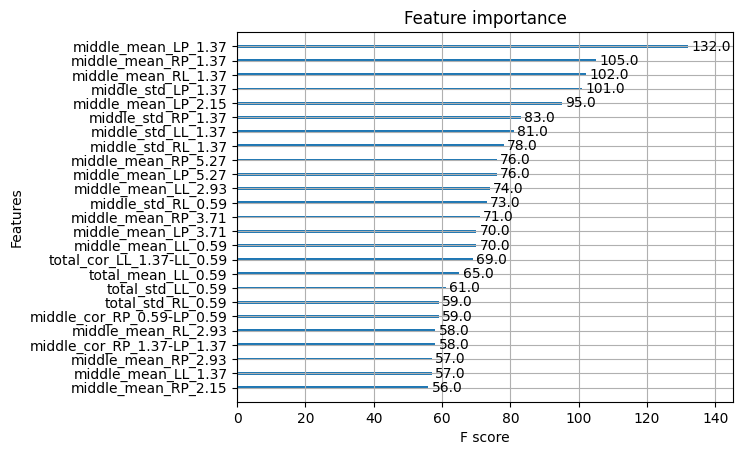

In [8]:
xgb.plot_importance(xgb_mod, max_num_features=25)